In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 46572196.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


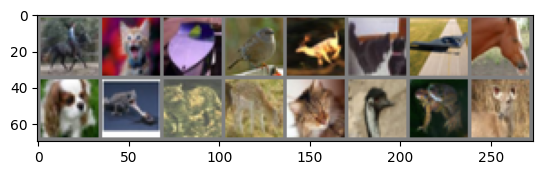

horse cat   ship  bird  deer  cat   plane horse dog   frog  cat   deer  cat   bird  frog  deer 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
images.shape

torch.Size([16, 3, 32, 32])

In [17]:
import torch
from torch import nn

class VGG19(nn.Module):
    def __init__(self,num_classes=1000, in_height=224,in_width=224):
        super().__init__()

        self.num_classes = num_classes
        self.height = in_height
        self.width = in_width
        self.num_hidden = 4096

        self.block_1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.block_2= nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.block_3= nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.block_5 = nn.Sequential(
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.FC_Block = self.fcs_Block()

        self.softmax = nn.Softmax(dim=1)

    def fcs_Block(self):


        pool_count = 5
        factor = (2 ** pool_count)
        # if (self.height % factor) + (self.width % factor) != 0:
        #     raise ValueError(
        #         f"`in_height` and `in_width` must be multiples of {factor}"
        #     )
        out_height = self.height // factor
        out_width = self.width // factor

        return nn.Sequential(
            nn.Linear(512 * out_height * out_width,self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(self.num_hidden, self.num_classes)
        )


        # x = nn.ReLU()(nn.Linear(,4096)(input))

        # x =nn.ReLU()(nn.Linear(4096,4096)(x))

        # x = nn.ReLU()(nn.Linear(4096,self.num_class)(x))

        # return x


    def forward(self,input):
        x = self.block_1(input)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        x_reshape = x.reshape(x.shape[0],-1)
        #print(x_reshape.shape)
        x = self.FC_Block(x_reshape)
        out = self.softmax(x)

        return out

In [18]:
model = VGG19(10,32,32).to(device)

In [19]:
model

VGG19(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(12

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [21]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels =  data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.238
[2,  2000] loss: 2.205
[3,  2000] loss: 2.183
[4,  2000] loss: 2.169
[5,  2000] loss: 2.164
[6,  2000] loss: 2.149
[7,  2000] loss: 2.125
[8,  2000] loss: 2.119
[9,  2000] loss: 2.113
[10,  2000] loss: 2.103
[11,  2000] loss: 2.114
[12,  2000] loss: 2.103
[13,  2000] loss: 2.107
[14,  2000] loss: 2.100
[15,  2000] loss: 2.093
[16,  2000] loss: 2.087
[17,  2000] loss: 2.084
[18,  2000] loss: 2.077
[19,  2000] loss: 2.073
[20,  2000] loss: 2.064
[21,  2000] loss: 2.057
[22,  2000] loss: 2.060
[23,  2000] loss: 2.047
[24,  2000] loss: 2.061
[25,  2000] loss: 2.051
[26,  2000] loss: 2.057
[27,  2000] loss: 2.058
[28,  2000] loss: 2.034
[29,  2000] loss: 2.027
[30,  2000] loss: 2.067
Finished Training
